# Transient with MCMC Hammer

## Time to get your hands dirty.  The transient Universe

Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:

1. Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]
2. Sudden flares of active galactic nuclei
3. Supernovae.

### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import emcee as mc
import scipy.stats as sp
import corner
from IPython.display import display, Math

Download and look at the dataset

(100, 3)


Text(0.5, 0, 'Time')

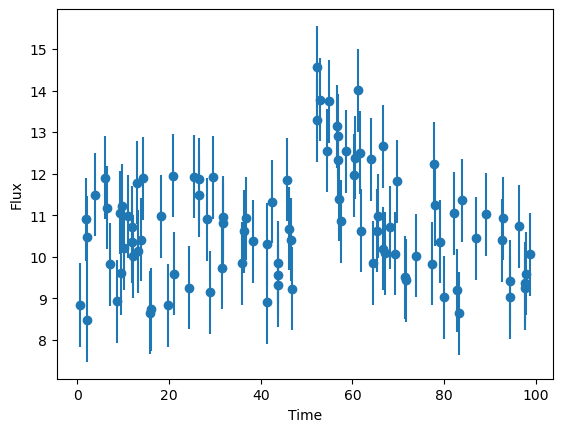

In [2]:
dataset = np.load('transient.npy')
print(np.shape(dataset))

plt.errorbar(dataset[:,0], dataset[:,1], dataset[:,2], ls = 'None', marker = 'o')
plt.ylabel('Flux')
plt.xlabel('Time')

## MCMC 

I assume gaussian error distribution, the likelihood will be the product of gaussian with the model 'Burst' instead of mu.

The only prior that is not constant is the one for alpha, the other I can put zero because the log will go to -inf when I'm out of range, therefore if the parameter is outside the range, the posterior will be at -inf and the MCMC will avoid the point

In [3]:
# Model function
def Burst (time, param):
    
    A, b, to, alpha = param
    model_f = np.zeros(len(time))
    
    for i in range(len(time)):
        
        if time[i] >= to:
            
            model_f[i] = b + A * np.exp(- alpha *(time[i] - to))
            
        else: model_f[i] = b

    return model_f

def Log_Likelihood (param, time, flux, sigma):
     
    # Here I can take directly the log: less computations
    log_L_i = (flux - Burst(time, param))**2 / (sigma**2)
    return -0.5 * np.sum(log_L_i) 

# Priors for each parameter
def A_prior (param):
    
    A, b, to, alpha = param
    
    if A_min <= A <= A_max:
        return 1/(A_max - A_min)
    return 0  

def b_prior (param):
    
    A, b, to, alpha = param
    if b_min <= b <= b_max:
        return 1/(b_max - b_min)
    return 0

def to_prior (param):
    
    A, b, to, alpha = param
    if to_min <= to <= to_max:
        return 1/(to_max - to_min)
    return 0

def alpha_prior (param):
    
    A, b, to, alpha = param
    
    if alpha_min <= alpha <= alpha_max:
        return 1/alpha
    return 0

# Alternative definition where the conditions must be all satisfied!
# Examples and professor's solution

# def total_prior (param):
    
#     A, b, to, alpha = param
    
#     if A_min < A < A_max and b_min < b < b_max and to_min < to < to_max and alpha_min < alpha < alpha_max:
#         return 0.0 - np.log(alpha)
    
#     return -np.inf

# Posterior with a check for the infinity 
def Log_Posterior (param, time, flux, sigma):
    
    log_prior = np.log( b_prior(param) * A_prior(param) * to_prior(param) * alpha_prior(param) )
    
    if not np.isfinite(log_prior):
        return -np.inf
   
    return Log_Likelihood(param, time, flux, sigma) + log_prior

Let's try to guess the parameters of the model and get a feeling with them; maybe you can do a more accurate job fitting with a MLE

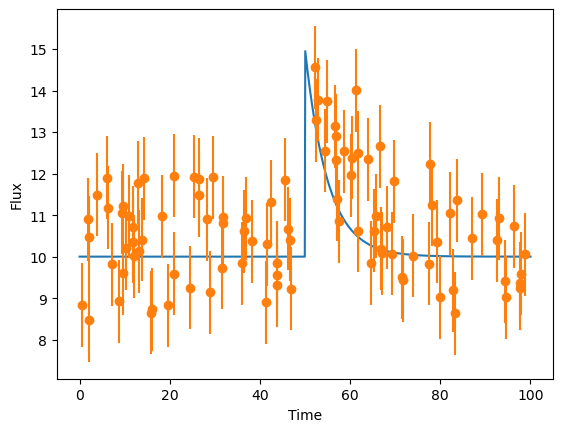

In [4]:
t_grid = np.linspace(0, 100, 1000)
try_param = [5, 10, 50, 0.2]
plt.plot(t_grid, Burst(t_grid, try_param))
plt.errorbar(dataset[:,0], dataset[:,1], dataset[:,2], ls = 'None', marker = 'o')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.show()

In [5]:
# Limitis of the parameters' priors
to_min, to_max = 0, 100
A_min, A_max = 0, 50
b_min, b_max = 0, 50
alpha_min, alpha_max = np.exp(-5), np.exp(5)

Now I run the MCMC algorithm

In [6]:
ndim = 4  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 40000  # number of MCMC steps to take (for each walker)

# initialize theta (parameters guesses, by eye from dataset + perturbation) 
starting_guesses = np.random.random((nwalkers, ndim)) + [5, 10, 55, 0.1]
#print(np.shape(starting_guesses))

# call the MCMC method and run it!
sampler = mc.EnsembleSampler(nwalkers, ndim, Log_Posterior, args = (dataset[:,0], dataset[:,1], dataset[:,2]))
sampler.run_mcmc(starting_guesses, nsteps, progress = True)

# Here I get the autocorrelation time
tau = sampler.get_autocorr_time()
print('Autocorrelation time for each parameter: ', tau)

# Here the acceptance factor, it's around 50% for each walker,
# it's quite high, maybe beacuse I selected initial conditions not too far
# from the maximum of the posterior?
acceptance_fraction = sampler.acceptance_fraction
print('Mean accepatance fraction: ', np.mean(acceptance_fraction))

# This is the same as .chain (professor's notes)  
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points, take into account the autocorr. time
# I take the maximum of the autoc. time because I want to be sure that
# the samples for each parameter are uncorrelated

samples = sampler.get_chain(flat = True, thin = int(np.max(tau)), discard = burn)
print(np.shape(samples))

#print(emcee_trace[0,0])
#emcee_trace.flatten()

(20, 4)


  0%|                                                 | 0/40000 [00:00<?, ?it/s]/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_73694/663262095.py:69: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log( b_prior(param) * A_prior(param) * to_prior(param) * alpha_prior(param) )
100%|███████████████████████████████████| 40000/40000 [00:33<00:00, 1179.73it/s]


Autocorrelation time for each parameter:  [75.15044298 63.61729353 84.86425841 87.33875552]
Mean accepatance fraction:  0.5296775000000001
(8960, 4)


Let's do some Trace plots for diagnostics before looking at the results

In [7]:
# labels for the plotting
labels = ["A","b", "$t_0$", "$\\alpha$"]

# Function for the trace plot
def Trace_plot (parameter_number, trace, data):
    
    fig = plt.figure(figsize=(15, 9))
    fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)
    
    chain = trace[:,parameter_number]
    M = np.size(chain)
    
    ax1 = fig.add_subplot(121)
    xgrid = np.linspace(1, M, M)
    plt.plot(xgrid, chain, c = 'green')
    ax1.axis([0, M, np.min(chain), 1.1 * np.max(chain)])
    plt.xlabel('number of samples',fontsize=15)
    plt.ylabel('chain',fontsize=15)
    
    chain_mean = np.mean(chain)
    ax1.axhline(chain_mean, c = 'red', label = 'chain mean', ls = '--') 
    ax1.legend(fontsize = 15)
    ax1.set_title('Trace plot')
    
    ax2 = fig.add_subplot(122)
    # skip first burn samples
    burn = 1000
    Nchain = np.size(chain[xgrid > burn])
    Nhist, bins, patches = plt.hist(chain[xgrid > burn], bins='auto', histtype='stepfilled', color = 'green')
    
    ax2.set_ylabel('p(chain)',fontsize=15)
    ax2.set_xlabel(labels[parameter_number],fontsize=15)
    ax2.set_xlim(np.min(chain[burn:]) - 0.5, np.max(chain[burn:]) + 0.5)
    ax2.axvline(np.quantile(chain[xgrid > burn], 0.5), c = 'r', lw = 2, label = 'median')
    ax2.axvline(np.quantile(chain[xgrid > burn], 0.05), ls = '--', c = 'r', lw = 2)
    ax2.axvline(np.quantile(chain[xgrid > burn], 0.95), ls = '--', c = 'r', lw = 2, label = '95% credibility')
    #ax2.set_ylim(0, 1.1 * np.max(gauss))
    ax2.legend(fontsize = 15)
    ax2.set_title(r'Chain from emcee',fontsize=15)

    return 

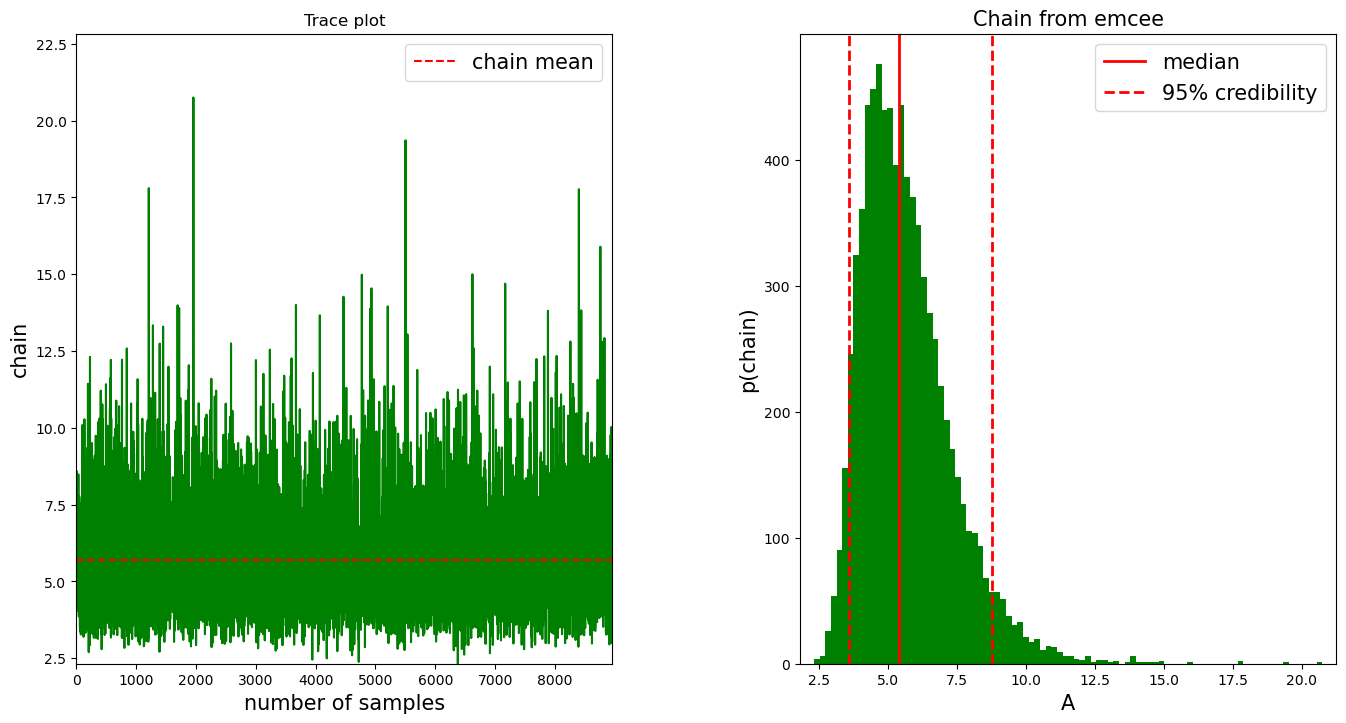

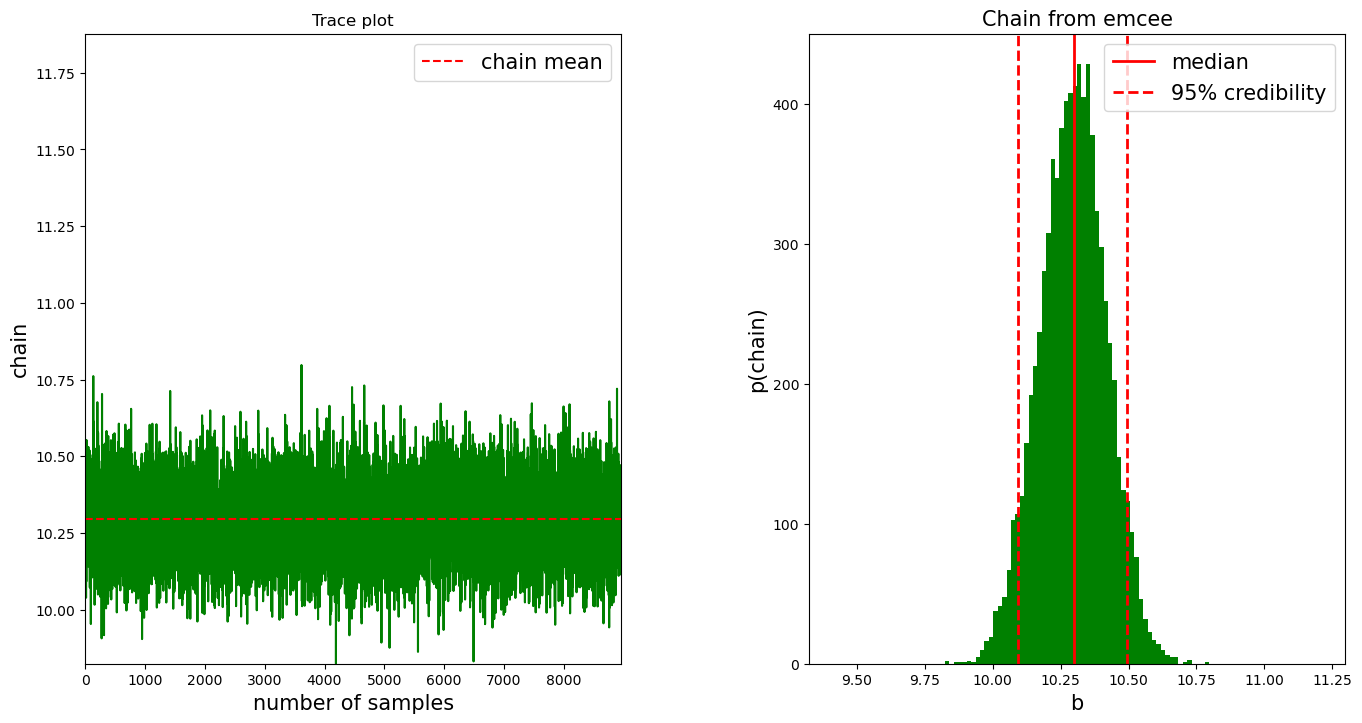

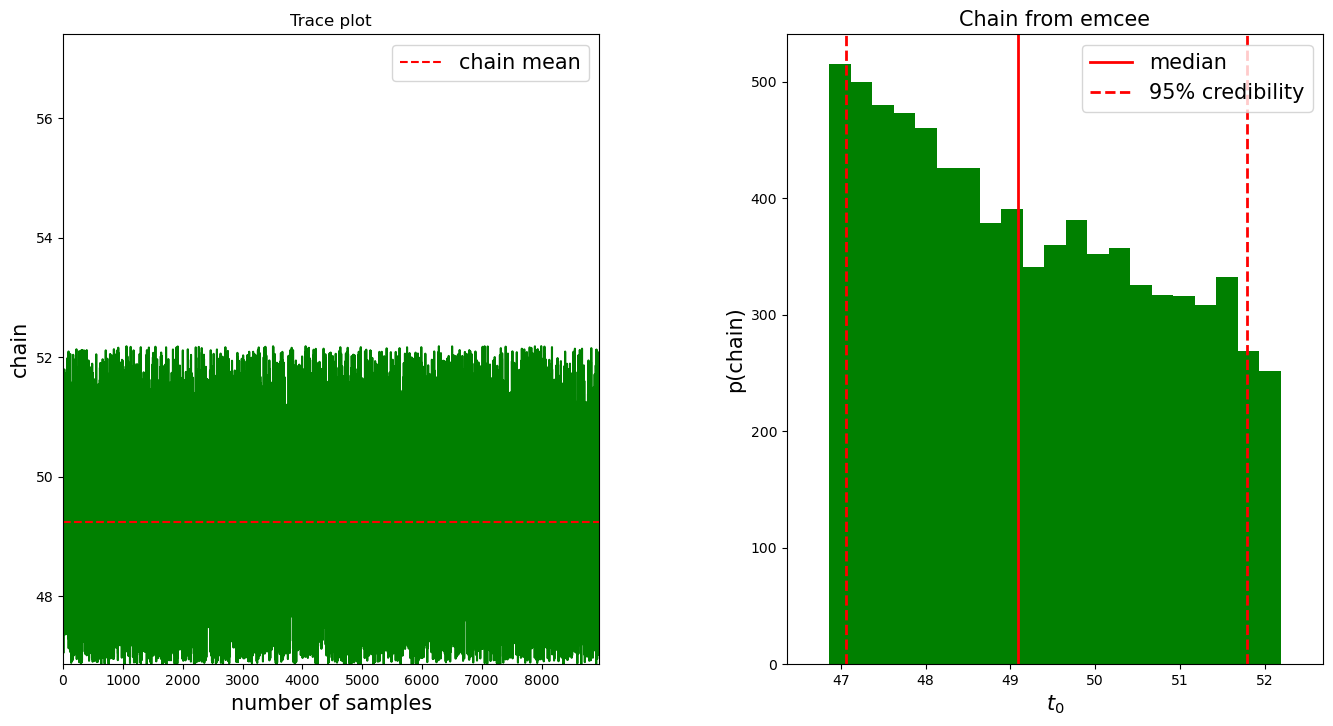

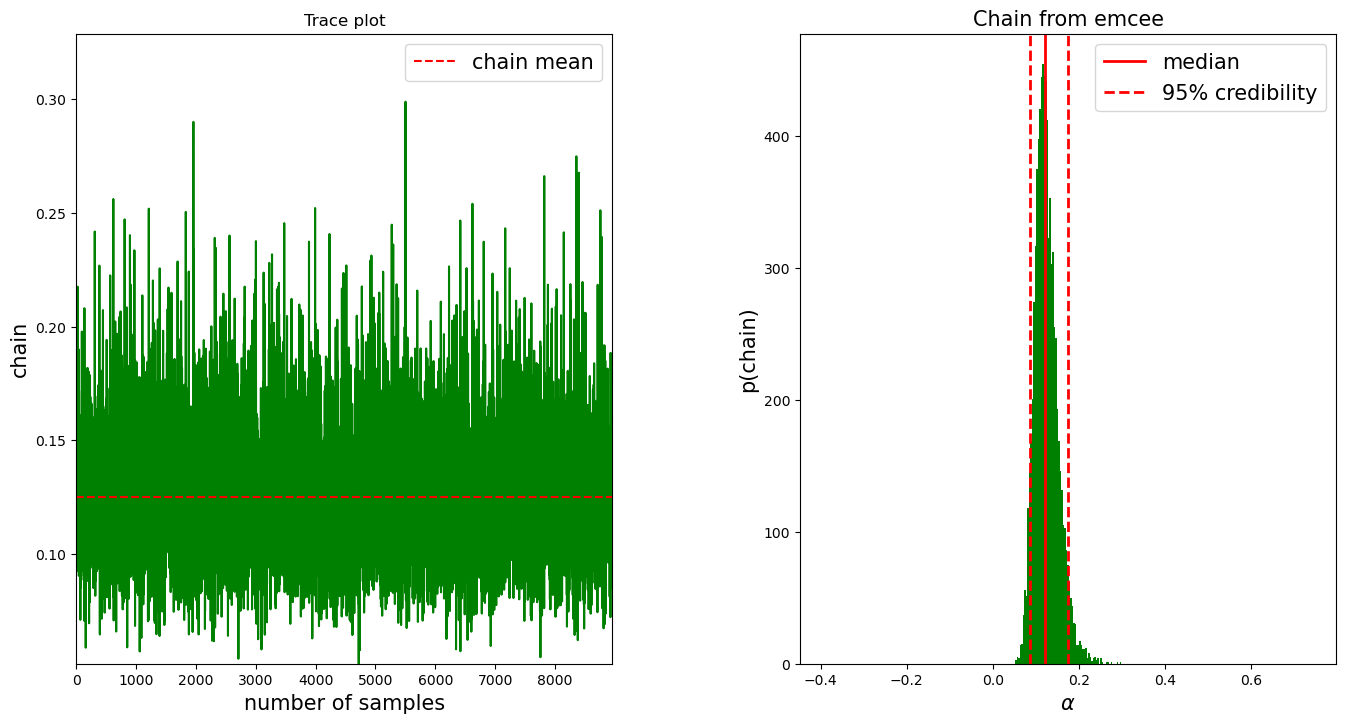

In [8]:
Trace_plot(0, samples, dataset) # Trace_plot and histo for A
Trace_plot(1, samples, dataset) # Trace_plot and histo for B
Trace_plot(2, samples, dataset) # Trace_plot and histo for to
Trace_plot(3, samples, dataset) # Trace_plot and histo for alpha

Now make a corner plot of the posterior distributions

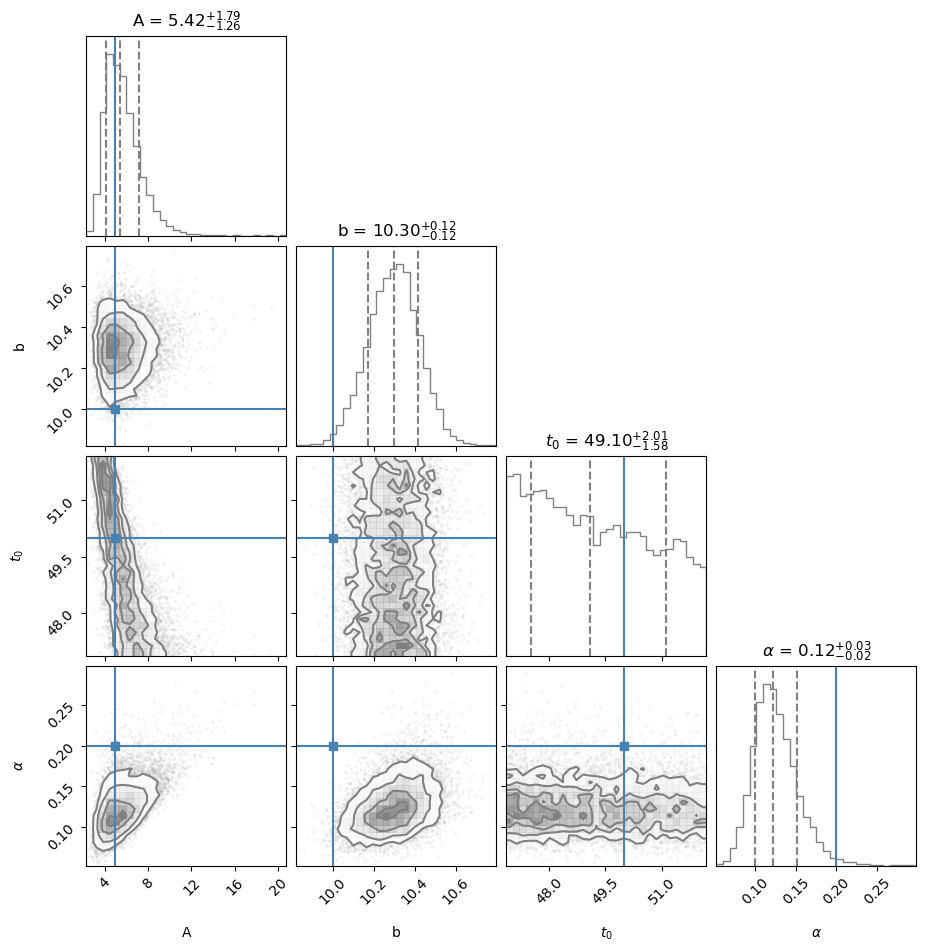

In [9]:
medians = np.array([np.median(samples[:,i])for i in range(ndim)])

figure = corner.corner(samples, bins = 30, color = 'grey',
            labels = labels, 
            quantiles = [0.16, 0.5, 0.84],
            truths = [5, 10, 50, 0.2], # Initial guess
            #levels = [0.68, 0.95] contonurs on the 2D plot
            show_titles = True, 
            title_kwargs={"fontsize": 12})

plt.show()

Here I choose randomly 100 different models from the MCMC sample and plot them over the data, then plot the stats in a nice format

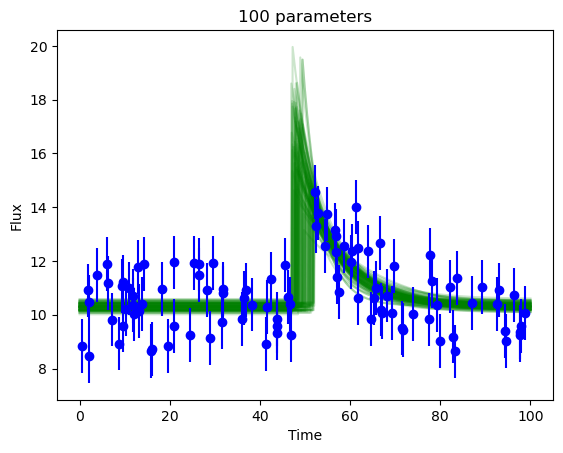

In [10]:
timegrid = np.linspace(0,100, 1000)

for i in np.random.randint(0, len(samples[:,1]), 100):

    plt.plot(timegrid, Burst(timegrid, [samples[i,0], samples[i,1], samples[i,2], samples[i,3]]), alpha = 0.2, c = 'g')
    
plt.errorbar(dataset[:,0], dataset[:,1], dataset[:,2], c = 'blue', ls = 'None', marker = 'o')
plt.title('100 parameters')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.show()

In [11]:
par_names = ['A', 'b', 't_0', '\\alpha']

for i in range(ndim):
    mcmc = np.quantile(samples[:, i], [0.05, 0.5, 0.95])
    q = np.diff(mcmc)
    txt = par_names[i] + " = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], par_names[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>